In [88]:
from collections import Counter
import nltk
import spacy
import re
import pandas as pd
import sklearn
import numpy as np
import markovify
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Natural Language Processing

# Predictions, Text Generation, and Chat Bot Creation

### **Project Background Information:**

As the years progress, we consume and are exposed to a vast amount of news and information online. 2020 seems to have highlighted how quickly news can spread- for better or worse. Using **3,950 scraped headlines** from valid and satirical news sources including The Onion, The New York Times, and others. **Bag of Words**, **1-gram**, **2-gram**, **1/2-gram**, **3-gram**, **Tf-idf**, and **Tf-idf/2-gram** were used for language modeling and compared using **logistic regression**, **random forest**, and **gradient boosting models** to predict fake and real headlines. 

Additionally, **text generation** was accomplished by implementing **Markov Chain models** with both fake and real headlines. A **chatbot** was also created using fake headlines.

# News Headline Predictions

## Valid & Satirical Sources

## Research Question: 

*Can we create a model that can accurately predict whether a news source is valid based on the headline alone?*

## Target Audience & Impact:

It could be argued that there are not many people who wouldn't be positively impacted by having the ability to more accurately and swiftly identify real and valid sources of information.

## Business Interests:

Fact checking, real-time analysis of events, etc.

## Examine Data

**Note:** Valid and satirical news sources were scraped, headlines isolated, cleaned, and used to create data frames in notebooks which were designated for these purposes. 

During the cleaning process, extra spaces and new lines were removed, as were non-headlines (such as "Follow Us," names of sections, ads, etc.) and the infrequent instances in which real news broke through the satire.

In [89]:
# import and read csv file

news_headlines = pd.read_csv(r'/Users/thisiskatcooper/Desktop/news_headlines.csv')

news_headlines.head()

,Headlines,Valid Source,Source
0,"Chris Wallace: Trump ""bears the primary respon...",Yes,Axios
1,Biden to expand voter outreach with in-person ...,Yes,Axios
2,Doomsday has arrived for tens of thousands of ...,Yes,Axios
3,"Pfizer CEO: COVID-19 vaccine development is ""m...",Yes,Axios
4,Anne Helen Petersen on America's burnout epidemic,Yes,Axios


In [90]:
news_headlines.shape

(3957, 3)

In [91]:
# drop duplicate headlines

news_headlines = news_headlines.drop_duplicates(subset=['Headlines'])

In [92]:
news_headlines.shape

(3950, 3)

**Data frame contains 3,950 headlines and 3 columns.**

In [93]:
news_headlines['Valid Source'].value_counts()

No     1975
Yes    1975
Name: Valid Source, dtype: int64

Data frame contains 1,975 headlines with valid sources (Yes) and 1,975 headlines with satirical sources (No).

In [94]:
# examine distribution of news sources

news_headlines['Source'].value_counts()

The Onion                  1064
The Guardian                530
The Washington Post         431
Squib                       401
Spoof                       231
The New York Times          210
NPR                         207
BBC                         201
The Chicago Tribune          87
True North                   87
Politico                     74
Beaverton                    66
Axios                        65
The Atlantic                 61
TIME                         58
The Economist                51
Waterford Whispers News      41
Click Hole                   24
National Report              18
Weekly World News            17
News Mutiny                  17
News Biscuit                  9
Name: Source, dtype: int64

**Valid sources** include The Guardian, The Washington Post, The New York Times, NPR, BBC, The Chicago Tribune, Politico, Axios, The Atlantic, and The Economist.

**Satirical sources** inclue The Onion, Squib, Spoof, True North, Beaverton, Waterford Whispers News, Click Hole, National Report, Weekly World News, News Mutiny, and News Biscuit.

**Note:** Satirical news sources are not updated as often as the valid news sources, for fairly obvious reasons (including budget/staff). The Onion proved to be the most updated satirical news website of those selected for this project. Each of the valid and satirical news sources is based in the U.K., U.S.A., or Canada. The headlines are also limited to one language, English, primarily because of time constraints!

In [95]:
# check for null values

news_headlines.isnull().sum()

Headlines       0
Valid Source    0
Source          0
dtype: int64

In [96]:
# convert 'Valid Source' to zeroes and ones using map

news_headlines['Valid Source'] = news_headlines['Valid Source'].map({'Yes': 1, 'No': 0})

news_headlines.head()

,Headlines,Valid Source,Source
0,"Chris Wallace: Trump ""bears the primary respon...",1,Axios
1,Biden to expand voter outreach with in-person ...,1,Axios
2,Doomsday has arrived for tens of thousands of ...,1,Axios
3,"Pfizer CEO: COVID-19 vaccine development is ""m...",1,Axios
4,Anne Helen Petersen on America's burnout epidemic,1,Axios


Converted Valid Source column to binary. Yes = 1, No = 0.

**Target = valid/real headline source.**

In [97]:
# check for null values after conversion

news_headlines.isnull().sum()

Headlines       0
Valid Source    0
Source          0
dtype: int64

# Feature Engineering

# Bag of Words

In [98]:
# vectorize using bag of words

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='word')
X = vectorizer.fit_transform(news_headlines['Headlines'])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
bow_headlines = pd.concat([bow_df, news_headlines[['Headlines', 'Valid Source']]], axis=1)

bow_headlines.head()

,000,10,100,100b,100th,101,10m,11,12,120,...,zone,zoo,zoologists,zoom,zoos,zucchini,zuckerberg,zverev,Headlines,Valid Source
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Chris Wallace: Trump ""bears the primary respon...",1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Biden to expand voter outreach with in-person ...,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Doomsday has arrived for tens of thousands of ...,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Pfizer CEO: COVID-19 vaccine development is ""m...",1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Anne Helen Petersen on America's burnout epidemic,1.0


In [99]:
bow_df.shape

(3950, 9378)

In [100]:
# check for null values

bow_df.isnull().sum()

000           0
10            0
100           0
100b          0
100th         0
             ..
zoom          0
zoos          0
zucchini      0
zuckerberg    0
zverev        0
Length: 9378, dtype: int64

In [101]:
bow_df = bow_df.dropna()

bow_df.shape

(3950, 9378)

In [102]:
bow_headlines.shape

(3952, 9380)

In [103]:
# check for null values

bow_headlines.isnull().sum()

000             2
10              2
100             2
100b            2
100th           2
               ..
zucchini        2
zuckerberg      2
zverev          2
Headlines       2
Valid Source    2
Length: 9380, dtype: int64

In [104]:
bow_headlines = bow_headlines.dropna()

bow_headlines.shape

(3948, 9380)

### Baseline Prediction - Bag of Words

In [105]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

# split

Y = bow_headlines['Valid Source']
X = np.array(bow_headlines.drop(['Headlines','Valid Source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

baseline_prediction = DummyClassifier(strategy='most_frequent')
baseline_prediction.fit(X, Y)
baseline_prediction.score(X_test, y_test)

0.5025316455696203

In [106]:
print('----------------------Baseline Prediction Report - Bag of Words----------------------\n')
print(classification_report(y_test, baseline_prediction.predict(X_test), target_names=['Fake Headlines', 'Valid Headlines']))
print('Training set score:', baseline_prediction.score(X_train, y_train))
print('Test set score:', baseline_prediction.score(X_test, y_test))

----------------------Baseline Prediction Report - Bag of Words----------------------

                 precision    recall  f1-score   support

 Fake Headlines       0.00      0.00      0.00       393
Valid Headlines       0.50      1.00      0.67       397

       accuracy                           0.50       790
      macro avg       0.25      0.50      0.33       790
   weighted avg       0.25      0.50      0.34       790

Training set score: 0.499683343888537
Test set score: 0.5025316455696203


### Logistic Regression Model & Scores - Bag of Words

In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [108]:
# create function to plot confusion matrix

import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion Matrix',
                          cmap=None,
                          normalize=True):
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [109]:
# initial setup

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)
lr_confusion = confusion_matrix(y_test, lr_predictions, labels=[1, 0])

In [110]:
# confirm values - confusion matrix

y_test.value_counts()

1.0    397
0.0    393
Name: Valid Source, dtype: int64

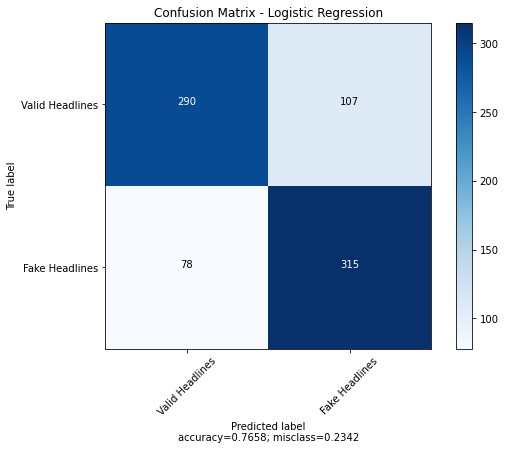

In [111]:
# plot the confusion matrix

plot_confusion_matrix(cm=lr_confusion, target_names = ['Valid Headlines', 'Fake Headlines'], title = 'Confusion Matrix - Logistic Regression', normalize=False)

In [112]:
# print report - fake & valid headlines - logistic regression

print('----------------------Logistic Regression Report - Bag of Words----------------------\n')
print(classification_report(y_test, lr_predictions, target_names=['Fake Headlines', 'Valid Headlines']))
print('Training set score:', lr.score(X_train, y_train))
print('Test set score:', lr.score(X_test, y_test))

----------------------Logistic Regression Report - Bag of Words----------------------

                 precision    recall  f1-score   support

 Fake Headlines       0.75      0.80      0.77       393
Valid Headlines       0.79      0.73      0.76       397

       accuracy                           0.77       790
      macro avg       0.77      0.77      0.77       790
   weighted avg       0.77      0.77      0.77       790

Training set score: 0.981000633312223
Test set score: 0.7658227848101266


In [231]:
# create a dataframe to compare stats

stats_data = {'F. E. Method' : ['Bag of Words'],
              'Model Name' : ['Logistic Regression'],
              'Training Set Score' : ['0.98100'],
              'Test Set Score' : ['0.76582'],
              'Precision - Fake Headlines' : ['0.75'],
              'Precision - Valid Headlines' : ['0.79'],
              'Recall - Fake Headlines' : ['0.80'],
              'Recall - Valid Headlines' : ['0.73'],
              'F1-Score - Fake Headlines' : ['0.77'],
              'F1-Score - Valid Headlines' : ['0.76']
    
}

stats_df = pd.DataFrame (stats_data, columns = ['F. E. Method', 'Model Name', 'Training Set Score', 'Test Set Score',
                                               'Precision - Fake Headlines', 'Precision - Valid Headlines',
                                               'Recall - Fake Headlines', 'Recall - Valid Headlines', 
                                               'F1-Score - Fake Headlines', 'F1-Score - Valid Headlines'])

stats_df.head()

,F. E. Method,Model Name,Training Set Score,Test Set Score,Precision - Fake Headlines,Precision - Valid Headlines,Recall - Fake Headlines,Recall - Valid Headlines,F1-Score - Fake Headlines,F1-Score - Valid Headlines
0,Bag of Words,Logistic Regression,0.98100,0.76582,0.75,0.79,0.80,0.73,0.77,0.76


### Random Forest Model & Scores - Bag of Words

In [114]:
# initial setup

rfc = RandomForestClassifier(random_state=10)
rfc.fit(X_train, y_train)
rfc_predictions = rfc.predict(X_test)
rfc_confusion = confusion_matrix(y_test, rfc_predictions, labels=[1, 0])

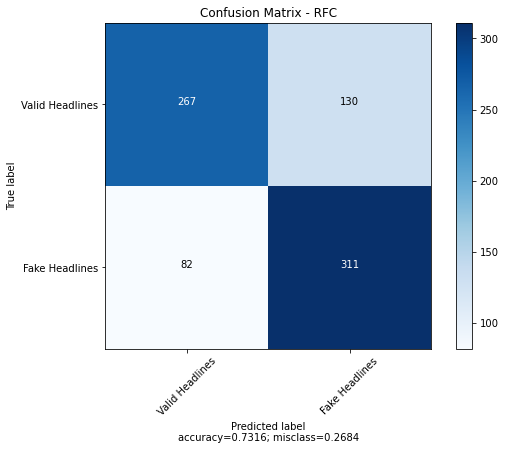

In [115]:
# plot the confusion matrix

plot_confusion_matrix(cm=rfc_confusion, target_names = ['Valid Headlines', 'Fake Headlines'], title = 'Confusion Matrix - RFC', normalize=False)

In [116]:
# print report - fake & valid headlines - rfc

print('----------------------Random Forest Report - Bag of Words----------------------\n')
print(classification_report(y_test, rfc_predictions, target_names=['Fake Headline', 'Valid Headline']))
print('Training set score:', rfc.score(X_train, y_train))
print('Test set score:', rfc.score(X_test, y_test))

----------------------Random Forest Report - Bag of Words----------------------

                precision    recall  f1-score   support

 Fake Headline       0.71      0.79      0.75       393
Valid Headline       0.77      0.67      0.72       397

      accuracy                           0.73       790
     macro avg       0.74      0.73      0.73       790
  weighted avg       0.74      0.73      0.73       790

Training set score: 1.0
Test set score: 0.7316455696202532


In [232]:
# update stats

stats_df = stats_df.append(pd.Series(['Bag of Words','Random Forest',
              '1.0', '0.73164', '0.71', '0.77', '0.79', '0.67', '0.75', 
                '0.72'], index=stats_df.columns), ignore_index=True)

In [233]:
stats_df.head()

,F. E. Method,Model Name,Training Set Score,Test Set Score,Precision - Fake Headlines,Precision - Valid Headlines,Recall - Fake Headlines,Recall - Valid Headlines,F1-Score - Fake Headlines,F1-Score - Valid Headlines
0,Bag of Words,Logistic Regression,0.98100,0.76582,0.75,0.79,0.80,0.73,0.77,0.76
1,Bag of Words,Random Forest,1.0,0.73164,0.71,0.77,0.79,0.67,0.75,0.72


### Gradient-Boosting Model & Scores - Bag of Words

In [119]:
# initial setup

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gbc_predictions = gbc.predict(X_test)
gbc_confusion = confusion_matrix(y_test, gbc_predictions, labels=[1, 0])

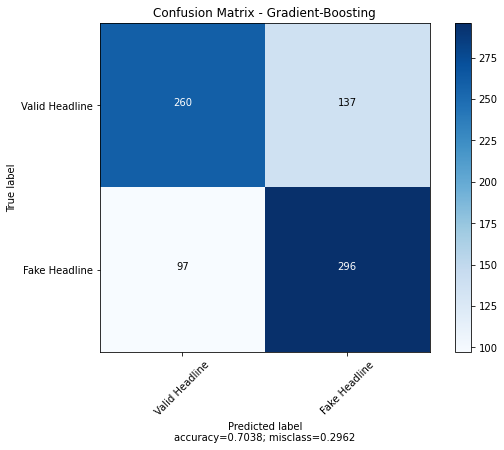

In [120]:
plot_confusion_matrix(cm=gbc_confusion, target_names = ['Valid Headline', 'Fake Headline'], title = 'Confusion Matrix - Gradient-Boosting', normalize=False)

In [121]:
# print report - fake & valid headlines - gradient-boosting

print('----------------------Gradient-Boosting Report - Bag of Words----------------------\n')
print(classification_report(y_test, gbc_predictions, target_names=['Fake Headline', 'Valid Headline']))
print('Training set score:', gbc.score(X_train, y_train))
print('Test set score:', gbc.score(X_test, y_test))

----------------------Gradient-Boosting Report - Bag of Words----------------------

                precision    recall  f1-score   support

 Fake Headline       0.68      0.75      0.72       393
Valid Headline       0.73      0.65      0.69       397

      accuracy                           0.70       790
     macro avg       0.71      0.70      0.70       790
  weighted avg       0.71      0.70      0.70       790

Training set score: 0.752691576947435
Test set score: 0.7037974683544304


In [234]:
# update stats

stats_df = stats_df.append(pd.Series(['Bag of Words','Gradient Boosting',
              '0.75269', '0.70379', '0.68', '0.73', '0.76', '0.65', '0.72', 
                '0.69'], index=stats_df.columns), ignore_index=True)

In [235]:
stats_df.head()

,F. E. Method,Model Name,Training Set Score,Test Set Score,Precision - Fake Headlines,Precision - Valid Headlines,Recall - Fake Headlines,Recall - Valid Headlines,F1-Score - Fake Headlines,F1-Score - Valid Headlines
0,Bag of Words,Logistic Regression,0.98100,0.76582,0.75,0.79,0.80,0.73,0.77,0.76
1,Bag of Words,Random Forest,1.0,0.73164,0.71,0.77,0.79,0.67,0.75,0.72
2,Bag of Words,Gradient Boosting,0.75269,0.70379,0.68,0.73,0.76,0.65,0.72,0.69


# 2gram

In [124]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,2))
X = vectorizer.fit_transform(news_headlines['Headlines'])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
two_gram_headlines = pd.concat([bow_df, news_headlines[['Headlines', 'Valid Source']]], axis=1)
two_gram_headlines.head()

,000 000,000 amazon,000 americans,000 child,000 coronavirus,000 corpses,000 covid,000 dead,000 employees,000 fans,...,zoom call,zoom camera,zoom class,zoom for,zoom lifted,zoom thanksgiving,zuckerberg announces,zverev in,Headlines,Valid Source
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Chris Wallace: Trump ""bears the primary respon...",1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Biden to expand voter outreach with in-person ...,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Doomsday has arrived for tens of thousands of ...,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Pfizer CEO: COVID-19 vaccine development is ""m...",1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Anne Helen Petersen on America's burnout epidemic,1.0


In [125]:
two_gram_headlines.isnull().sum()

000 000                 2
000 amazon              2
000 americans           2
000 child               2
000 coronavirus         2
                       ..
zoom thanksgiving       2
zuckerberg announces    2
zverev in               2
Headlines               2
Valid Source            2
Length: 30569, dtype: int64

In [126]:
two_gram_headlines.dropna(inplace=True)

In [127]:
two_gram_headlines.isnull().sum()

000 000                 0
000 amazon              0
000 americans           0
000 child               0
000 coronavirus         0
                       ..
zoom thanksgiving       0
zuckerberg announces    0
zverev in               0
Headlines               0
Valid Source            0
Length: 30569, dtype: int64

In [128]:
# split

Y = two_gram_headlines['Valid Source']
X = np.array(two_gram_headlines.drop(['Headlines','Valid Source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

### Logistic Regression Model & Scores - 2gram

In [129]:
# initial setup

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)
lr_confusion = confusion_matrix(y_test, lr_predictions, labels=[1,0])

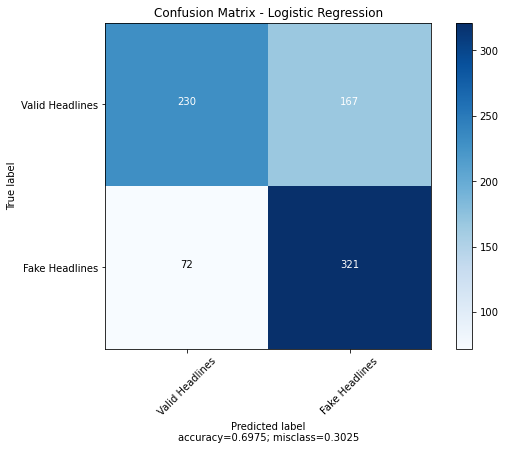

In [130]:
plot_confusion_matrix(cm=lr_confusion, target_names = ['Valid Headlines', 'Fake Headlines'], title = 'Confusion Matrix - Logistic Regression', normalize=False)

In [131]:
# print report - fake & valid headlines - logistic regression

print('----------------------Logistic Regression Report - 2grams----------------------\n')
print(classification_report(y_test, lr_predictions, target_names=['Fake Headlines', 'Valid Headlines']))
print('Training set score:', lr.score(X_train, y_train))
print('Test set score:', lr.score(X_test, y_test))

----------------------Logistic Regression Report - 2grams----------------------

                 precision    recall  f1-score   support

 Fake Headlines       0.66      0.82      0.73       393
Valid Headlines       0.76      0.58      0.66       397

       accuracy                           0.70       790
      macro avg       0.71      0.70      0.69       790
   weighted avg       0.71      0.70      0.69       790

Training set score: 0.9996833438885371
Test set score: 0.6974683544303798


In [236]:
# update stats

stats_df = stats_df.append(pd.Series(['2gram','Logistic Regression',
              '0.99968', '0.69747', '0.66', '0.76', '0.82', '0.58', '0.73', 
                '0.66'], index=stats_df.columns), ignore_index=True)

In [237]:
stats_df.head()

,F. E. Method,Model Name,Training Set Score,Test Set Score,Precision - Fake Headlines,Precision - Valid Headlines,Recall - Fake Headlines,Recall - Valid Headlines,F1-Score - Fake Headlines,F1-Score - Valid Headlines
0,Bag of Words,Logistic Regression,0.98100,0.76582,0.75,0.79,0.80,0.73,0.77,0.76
1,Bag of Words,Random Forest,1.0,0.73164,0.71,0.77,0.79,0.67,0.75,0.72
2,Bag of Words,Gradient Boosting,0.75269,0.70379,0.68,0.73,0.76,0.65,0.72,0.69
3,2gram,Logistic Regression,0.99968,0.69747,0.66,0.76,0.82,0.58,0.73,0.66


### Random Forest Model & Scores - 2gram

In [134]:
# initial setup

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_predictions = rfc.predict(X_test)
rfc_confusion = confusion_matrix(y_test, rfc_predictions, labels=[1, 0])

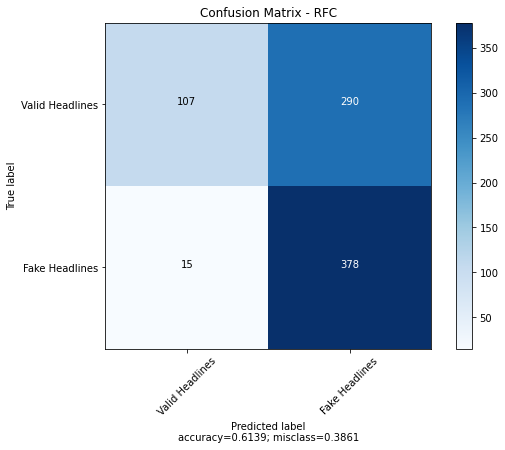

In [135]:
plot_confusion_matrix(cm=rfc_confusion, target_names = ['Valid Headlines', 'Fake Headlines'], title = 'Confusion Matrix - RFC', normalize=False)

In [136]:
# print report - fake & valid headlines - rfc

print('----------------------Random Forest Report - 2gram----------------------\n')
print(classification_report(y_test, rfc_predictions, target_names=['Fake Headlines', 'Valid Headlines']))
print('Training set score:', rfc.score(X_train, y_train))
print('Test set score:', rfc.score(X_test, y_test))

----------------------Random Forest Report - 2gram----------------------

                 precision    recall  f1-score   support

 Fake Headlines       0.57      0.96      0.71       393
Valid Headlines       0.88      0.27      0.41       397

       accuracy                           0.61       790
      macro avg       0.72      0.62      0.56       790
   weighted avg       0.72      0.61      0.56       790

Training set score: 0.9987333755541482
Test set score: 0.6139240506329114


In [238]:
# update stats

stats_df = stats_df.append(pd.Series(['2gram','Random Forest',
              '0.99937', '0.61392', '0.57', '0.87', '0.96', '0.27', '0.71', 
                '0.41'], index=stats_df.columns), ignore_index=True)

In [239]:
stats_df.head()

,F. E. Method,Model Name,Training Set Score,Test Set Score,Precision - Fake Headlines,Precision - Valid Headlines,Recall - Fake Headlines,Recall - Valid Headlines,F1-Score - Fake Headlines,F1-Score - Valid Headlines
0,Bag of Words,Logistic Regression,0.98100,0.76582,0.75,0.79,0.80,0.73,0.77,0.76
1,Bag of Words,Random Forest,1.0,0.73164,0.71,0.77,0.79,0.67,0.75,0.72
2,Bag of Words,Gradient Boosting,0.75269,0.70379,0.68,0.73,0.76,0.65,0.72,0.69
3,2gram,Logistic Regression,0.99968,0.69747,0.66,0.76,0.82,0.58,0.73,0.66
4,2gram,Random Forest,0.99937,0.61392,0.57,0.87,0.96,0.27,0.71,0.41


### Gradient-Boosting Model & Scores - 2gram

In [139]:
# initial setup

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gbc_predictions = gbc.predict(X_test)
gbc_confusion = confusion_matrix(y_test, gbc_predictions, labels=[1,0])

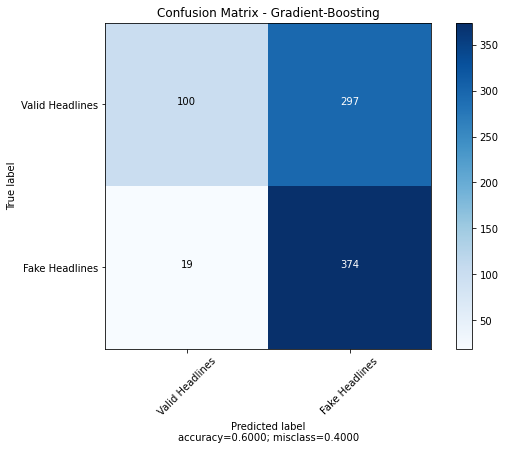

In [140]:
plot_confusion_matrix(cm=gbc_confusion, target_names = ['Valid Headlines', 'Fake Headlines'], title = 'Confusion Matrix - Gradient-Boosting', normalize=False)

In [141]:
# print report - fake & valid headlines - gradient-boosting

print('----------------------Gradient-Boosting Report - 2gram----------------------\n')
print(classification_report(y_test, gbc_predictions, target_names=['Fake Headlines', 'Valid Headlines']))
print('Training set score:', gbc.score(X_train, y_train))
print('Test set score:', gbc.score(X_test, y_test))

----------------------Gradient-Boosting Report - 2gram----------------------

                 precision    recall  f1-score   support

 Fake Headlines       0.56      0.95      0.70       393
Valid Headlines       0.84      0.25      0.39       397

       accuracy                           0.60       790
      macro avg       0.70      0.60      0.55       790
   weighted avg       0.70      0.60      0.54       790

Training set score: 0.6586447118429386
Test set score: 0.6


In [240]:
# update stats

stats_df = stats_df.append(pd.Series(['2gram','Gradient Boosting',
              '0.65484', '0.59747', '0.56', '0.83', '0.95', '0.25', '0.70', 
                '0.39'], index=stats_df.columns), ignore_index=True)

In [242]:
stats_df.tail()

,F. E. Method,Model Name,Training Set Score,Test Set Score,Precision - Fake Headlines,Precision - Valid Headlines,Recall - Fake Headlines,Recall - Valid Headlines,F1-Score - Fake Headlines,F1-Score - Valid Headlines
1,Bag of Words,Random Forest,1.0,0.73164,0.71,0.77,0.79,0.67,0.75,0.72
2,Bag of Words,Gradient Boosting,0.75269,0.70379,0.68,0.73,0.76,0.65,0.72,0.69
3,2gram,Logistic Regression,0.99968,0.69747,0.66,0.76,0.82,0.58,0.73,0.66
4,2gram,Random Forest,0.99937,0.61392,0.57,0.87,0.96,0.27,0.71,0.41
5,2gram,Gradient Boosting,0.65484,0.59747,0.56,0.83,0.95,0.25,0.70,0.39


# 1gram/2gram

In [144]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,2))
X = vectorizer.fit_transform(news_headlines['Headlines'])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
one_two_headlines = pd.concat([bow_df, news_headlines[['Headlines', 'Valid Source']]], axis=1)
one_two_headlines.head()

,000,000 000,000 amazon,000 americans,000 child,000 coronavirus,000 corpses,000 covid,000 dead,000 employees,...,zoom lifted,zoom thanksgiving,zoos,zucchini,zuckerberg,zuckerberg announces,zverev,zverev in,Headlines,Valid Source
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Chris Wallace: Trump ""bears the primary respon...",1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Biden to expand voter outreach with in-person ...,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Doomsday has arrived for tens of thousands of ...,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Pfizer CEO: COVID-19 vaccine development is ""m...",1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Anne Helen Petersen on America's burnout epidemic,1.0


In [145]:
# check for null values

one_two_headlines.isnull().sum()

000                     2
000 000                 2
000 amazon              2
000 americans           2
000 child               2
                       ..
zuckerberg announces    2
zverev                  2
zverev in               2
Headlines               2
Valid Source            2
Length: 39947, dtype: int64

In [146]:
one_two_headlines.dropna(inplace=True)

In [147]:
# confirm that null values have been dropped

one_two_headlines.isnull().sum()

000                     0
000 000                 0
000 amazon              0
000 americans           0
000 child               0
                       ..
zuckerberg announces    0
zverev                  0
zverev in               0
Headlines               0
Valid Source            0
Length: 39947, dtype: int64

In [148]:
# split

Y = one_two_headlines['Valid Source']
X = np.array(one_two_headlines.drop(['Headlines','Valid Source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

### Logistic Regression Model & Scores - 1gram/2gram

In [149]:
# logistic regression model & scores

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)
lr_confusion = confusion_matrix(y_test, lr_predictions, labels=[1, 0])

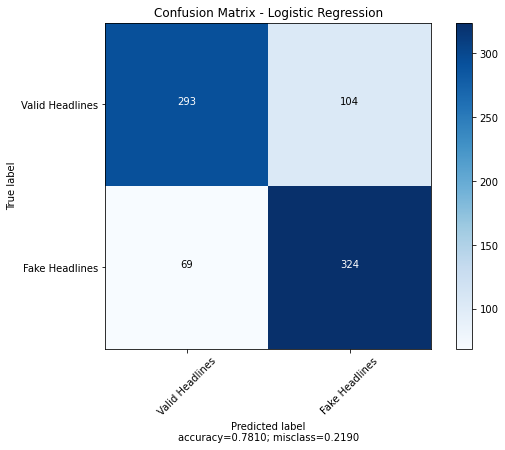

In [150]:
plot_confusion_matrix(cm=lr_confusion, target_names = ['Valid Headlines', 'Fake Headlines'], title = 'Confusion Matrix - Logistic Regression', normalize=False)

In [151]:
# print report - fake & valid headlines - logistic regression

print('----------------------Logistic Regression Report - 1gram/2gram----------------------\n')
print(classification_report(y_test, lr_predictions, target_names=['Fake Headlines', 'Valid Headlines']))
print('Training set score:', lr.score(X_train, y_train))
print('Test set score:', lr.score(X_test, y_test))

----------------------Logistic Regression Report - 1gram/2gram----------------------

                 precision    recall  f1-score   support

 Fake Headlines       0.76      0.82      0.79       393
Valid Headlines       0.81      0.74      0.77       397

       accuracy                           0.78       790
      macro avg       0.78      0.78      0.78       790
   weighted avg       0.78      0.78      0.78       790

Training set score: 1.0
Test set score: 0.7810126582278482


In [243]:
# update stats

stats_df = stats_df.append(pd.Series(['1gram/2gram','Logistic Regression',
              '1.0', '0.781013', '0.76', '0.81', '0.82', '0.74', '0.79', 
                '0.77'], index=stats_df.columns), ignore_index=True)

In [244]:
stats_df.tail()

,F. E. Method,Model Name,Training Set Score,Test Set Score,Precision - Fake Headlines,Precision - Valid Headlines,Recall - Fake Headlines,Recall - Valid Headlines,F1-Score - Fake Headlines,F1-Score - Valid Headlines
2,Bag of Words,Gradient Boosting,0.75269,0.70379,0.68,0.73,0.76,0.65,0.72,0.69
3,2gram,Logistic Regression,0.99968,0.69747,0.66,0.76,0.82,0.58,0.73,0.66
4,2gram,Random Forest,0.99937,0.61392,0.57,0.87,0.96,0.27,0.71,0.41
5,2gram,Gradient Boosting,0.65484,0.59747,0.56,0.83,0.95,0.25,0.70,0.39
6,1gram/2gram,Logistic Regression,1.0,0.781013,0.76,0.81,0.82,0.74,0.79,0.77


### Random Forest  Model & Scores - 1gram/2gram

In [154]:
# initial setup

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_predictions = rfc.predict(X_test)
rfc_confusion = confusion_matrix(y_test, rfc_predictions, labels=[1 ,0])

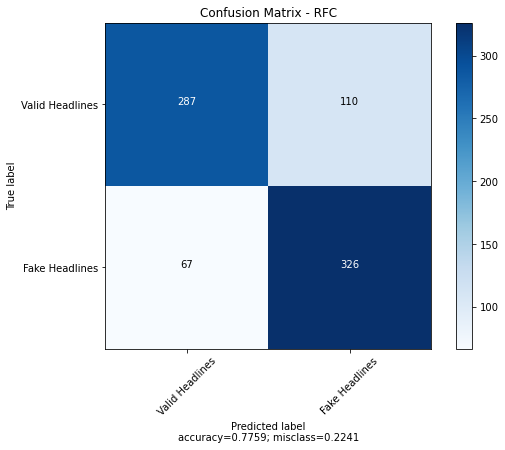

In [195]:
plot_confusion_matrix(cm=rfc_confusion, target_names = ['Valid Headlines', 'Fake Headlines'], title = 'Confusion Matrix - RFC', normalize=False)

In [156]:
# print report - fake & valid headlines - rfc

print('----------------------Random Forest Report - Random Forest- 1gram/2gram----------------------\n')
print(classification_report(y_test, rfc_predictions, target_names=['Fake Headlines', 'Valid Headlines']))
print('Training set score:', rfc.score(X_train, y_train))
print('Test set score:', rfc.score(X_test, y_test))

----------------------Random Forest Report - Random Forest- 1gram/2gram----------------------

                 precision    recall  f1-score   support

 Fake Headlines       0.69      0.83      0.75       393
Valid Headlines       0.79      0.63      0.70       397

       accuracy                           0.73       790
      macro avg       0.74      0.73      0.73       790
   weighted avg       0.74      0.73      0.73       790

Training set score: 1.0
Test set score: 0.7291139240506329


In [245]:
# update stats

stats_df = stats_df.append(pd.Series(['1gram/2gram','Random Forest',
              '1.0', '0.72911', '0.69', '0.79', '0.83', '0.63', '0.75', 
                '0.70'], index=stats_df.columns), ignore_index=True)

In [246]:
stats_df.tail()

,F. E. Method,Model Name,Training Set Score,Test Set Score,Precision - Fake Headlines,Precision - Valid Headlines,Recall - Fake Headlines,Recall - Valid Headlines,F1-Score - Fake Headlines,F1-Score - Valid Headlines
3,2gram,Logistic Regression,0.99968,0.69747,0.66,0.76,0.82,0.58,0.73,0.66
4,2gram,Random Forest,0.99937,0.61392,0.57,0.87,0.96,0.27,0.71,0.41
5,2gram,Gradient Boosting,0.65484,0.59747,0.56,0.83,0.95,0.25,0.70,0.39
6,1gram/2gram,Logistic Regression,1.0,0.781013,0.76,0.81,0.82,0.74,0.79,0.77
7,1gram/2gram,Random Forest,1.0,0.72911,0.69,0.79,0.83,0.63,0.75,0.70


### Gradient-Boosting Model & Scores - 1gram/2gram

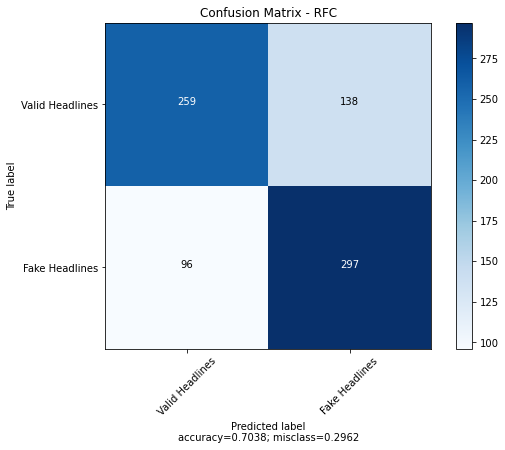

In [160]:
plot_confusion_matrix(cm=gbc_confusion, target_names = ['Valid Headlines', 'Fake Headlines'], title = 'Confusion Matrix - RFC', normalize=False)

In [161]:
# print report - fake & valid headlines - gradient-boosting

print('----------------------Gradient-Boosting Report - 1gram/2gram----------------------\n')
print(classification_report(y_test, gbc_predictions, target_names=['Fake Headlines', 'Valid Headlines']))
print('Training set score:', gbc.score(X_train, y_train))
print('Test set score:', gbc.score(X_test, y_test))

----------------------Gradient-Boosting Report - 1gram/2gram----------------------

                 precision    recall  f1-score   support

 Fake Headlines       0.68      0.76      0.72       393
Valid Headlines       0.73      0.65      0.69       397

       accuracy                           0.70       790
      macro avg       0.71      0.70      0.70       790
   weighted avg       0.71      0.70      0.70       790

Training set score: 0.7517416086130463
Test set score: 0.7037974683544304


In [247]:
# update stats

stats_df = stats_df.append(pd.Series(['1gram/2gram','Gradient Boosting',
              '0.75174', '0.70379', '0.68', '0.73', '0.76', '0.65', '0.72', 
                '0.69'], index=stats_df.columns), ignore_index=True)

In [248]:
stats_df.tail()

,F. E. Method,Model Name,Training Set Score,Test Set Score,Precision - Fake Headlines,Precision - Valid Headlines,Recall - Fake Headlines,Recall - Valid Headlines,F1-Score - Fake Headlines,F1-Score - Valid Headlines
4,2gram,Random Forest,0.99937,0.61392,0.57,0.87,0.96,0.27,0.71,0.41
5,2gram,Gradient Boosting,0.65484,0.59747,0.56,0.83,0.95,0.25,0.70,0.39
6,1gram/2gram,Logistic Regression,1.0,0.781013,0.76,0.81,0.82,0.74,0.79,0.77
7,1gram/2gram,Random Forest,1.0,0.72911,0.69,0.79,0.83,0.63,0.75,0.70
8,1gram/2gram,Gradient Boosting,0.75174,0.70379,0.68,0.73,0.76,0.65,0.72,0.69


# 3gram

In [164]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(3,3))
X = vectorizer.fit_transform(news_headlines['Headlines'])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
three_gram_headlines = pd.concat([bow_df, news_headlines[['Headlines', 'Valid Source']]], axis=1)
three_gram_headlines.head()

,000 000 in,000 amazon workers,000 americans killed,000 americans sign,000 child cases,000 coronavirus infected,000 corpses in,000 covid 19,000 dead trump,000 employees have,...,zoo separates parrots,zoologists thrilled after,zoom camera keeps,zoom for table,zoom lifted the,zoom thanksgiving dinner,zuckerberg announces virtual,zverev in action,Headlines,Valid Source
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Chris Wallace: Trump ""bears the primary respon...",1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Biden to expand voter outreach with in-person ...,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Doomsday has arrived for tens of thousands of ...,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Pfizer CEO: COVID-19 vaccine development is ""m...",1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Anne Helen Petersen on America's burnout epidemic,1.0


In [165]:
# check for null values

three_gram_headlines.isnull().sum()

000 000 in                      2
000 amazon workers              2
000 americans killed            2
000 americans sign              2
000 child cases                 2
                               ..
zoom thanksgiving dinner        2
zuckerberg announces virtual    2
zverev in action                2
Headlines                       2
Valid Source                    2
Length: 33242, dtype: int64

In [166]:
three_gram_headlines.dropna(inplace=True)

In [167]:
# confirm that null values have been dropped

three_gram_headlines.isnull().sum()

000 000 in                      0
000 amazon workers              0
000 americans killed            0
000 americans sign              0
000 child cases                 0
                               ..
zoom thanksgiving dinner        0
zuckerberg announces virtual    0
zverev in action                0
Headlines                       0
Valid Source                    0
Length: 33242, dtype: int64

In [168]:
# split

Y = three_gram_headlines['Valid Source']
X = np.array(three_gram_headlines.drop(['Headlines','Valid Source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

### Logistic Regression Model & Scores - 3gram

In [169]:
# initial setup

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)
lr_confusion = confusion_matrix(y_test, lr_predictions, labels=[1, 0])

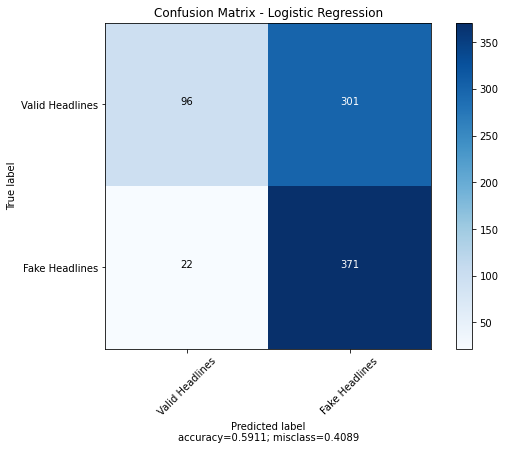

In [170]:
plot_confusion_matrix(cm=lr_confusion, target_names = ['Valid Headlines', 'Fake Headlines'], title = 'Confusion Matrix - Logistic Regression', normalize=False)

In [171]:
# print report - fake & valid headlines - logistic regression

print('----------------------Logistic Regression Report - 3gram----------------------\n')
print(classification_report(y_test, lr_predictions, target_names=['Fake Headlines', 'Valid Headlines']))
print('Training set score:', lr.score(X_train, y_train))
print('Test set score:', lr.score(X_test, y_test))

----------------------Logistic Regression Report - 3gram----------------------

                 precision    recall  f1-score   support

 Fake Headlines       0.55      0.94      0.70       393
Valid Headlines       0.81      0.24      0.37       397

       accuracy                           0.59       790
      macro avg       0.68      0.59      0.53       790
   weighted avg       0.68      0.59      0.53       790

Training set score: 0.999366687777074
Test set score: 0.5911392405063292


In [249]:
# update stats

stats_df = stats_df.append(pd.Series(['3gram','Logistic Regression',
              '0.99937', '0.59113', '0.55', '0.81', '0.94', '0.24', '0.70', 
                '0.37'], index=stats_df.columns), ignore_index=True)

In [250]:
stats_df.tail()

,F. E. Method,Model Name,Training Set Score,Test Set Score,Precision - Fake Headlines,Precision - Valid Headlines,Recall - Fake Headlines,Recall - Valid Headlines,F1-Score - Fake Headlines,F1-Score - Valid Headlines
5,2gram,Gradient Boosting,0.65484,0.59747,0.56,0.83,0.95,0.25,0.70,0.39
6,1gram/2gram,Logistic Regression,1.0,0.781013,0.76,0.81,0.82,0.74,0.79,0.77
7,1gram/2gram,Random Forest,1.0,0.72911,0.69,0.79,0.83,0.63,0.75,0.70
8,1gram/2gram,Gradient Boosting,0.75174,0.70379,0.68,0.73,0.76,0.65,0.72,0.69
9,3gram,Logistic Regression,0.99937,0.59113,0.55,0.81,0.94,0.24,0.70,0.37


### Random Forest Model & Scores - 3gram

In [174]:
# initial setup

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_predictions = rfc.predict(X_test)
rfc_confusion = confusion_matrix(y_test, rfc_predictions, labels=[1, 0])

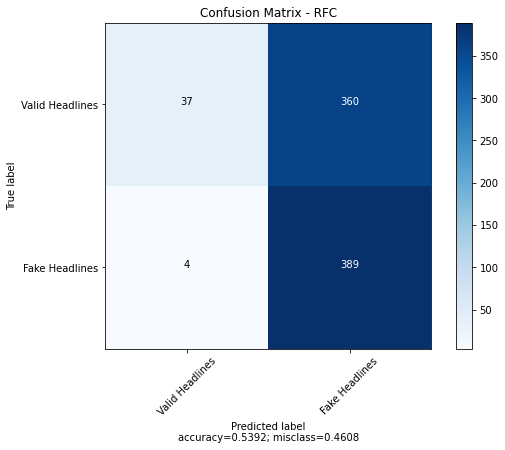

In [175]:
plot_confusion_matrix(cm=rfc_confusion, target_names = ['Valid Headlines', 'Fake Headlines'], title = 'Confusion Matrix - RFC', normalize=False)

In [176]:
# print report - fake & valid headlines - rfc

print('----------------------Random Forest Report - 3gram----------------------\n')
print(classification_report(y_test, rfc_predictions, target_names=['Fake Headlines', 'Valid Headlines']))
print('Training set score:', rfc.score(X_train, y_train))
print('Test set score:', rfc.score(X_test, y_test))

----------------------Random Forest Report - 3gram----------------------

                 precision    recall  f1-score   support

 Fake Headlines       0.52      0.99      0.68       393
Valid Headlines       0.90      0.09      0.17       397

       accuracy                           0.54       790
      macro avg       0.71      0.54      0.43       790
   weighted avg       0.71      0.54      0.42       790

Training set score: 0.999366687777074
Test set score: 0.5392405063291139


In [251]:
# update stats

stats_df = stats_df.append(pd.Series(['3gram','Random Forest',
              '0.99937', '0.53924', '0.52', '0.90', '0.99', '0.09', '0.68', 
                '0.17'], index=stats_df.columns), ignore_index=True)

In [252]:
stats_df.tail()

,F. E. Method,Model Name,Training Set Score,Test Set Score,Precision - Fake Headlines,Precision - Valid Headlines,Recall - Fake Headlines,Recall - Valid Headlines,F1-Score - Fake Headlines,F1-Score - Valid Headlines
6,1gram/2gram,Logistic Regression,1.0,0.781013,0.76,0.81,0.82,0.74,0.79,0.77
7,1gram/2gram,Random Forest,1.0,0.72911,0.69,0.79,0.83,0.63,0.75,0.70
8,1gram/2gram,Gradient Boosting,0.75174,0.70379,0.68,0.73,0.76,0.65,0.72,0.69
9,3gram,Logistic Regression,0.99937,0.59113,0.55,0.81,0.94,0.24,0.70,0.37
10,3gram,Random Forest,0.99937,0.53924,0.52,0.90,0.99,0.09,0.68,0.17


### Gradient-Boosting Model & Scores - 3gram

In [177]:
# gradient-boosting model & scores

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gbc_predictions = gbc.predict(X_test)
gbc_confusion = confusion_matrix(y_test, gbc_predictions, labels=[1 ,0])

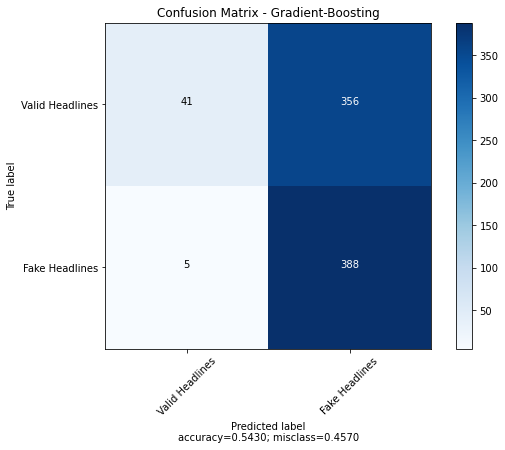

In [178]:
plot_confusion_matrix(cm=gbc_confusion, target_names = ['Valid Headlines', 'Fake Headlines'], title = 'Confusion Matrix - Gradient-Boosting', normalize=False)

In [179]:
# print report - fake & valid headlines - gradient-boosting

print('----------------------Gradient-Boosting Report - 3gram----------------------\n')
print(classification_report(y_test, gbc_predictions, target_names=['Fake Headlines', 'Valid Headlines']))
print('Training set score:', gbc.score(X_train, y_train))
print('Test set score:', gbc.score(X_test, y_test))

----------------------Gradient-Boosting Report - 3gram----------------------

                 precision    recall  f1-score   support

 Fake Headlines       0.52      0.99      0.68       393
Valid Headlines       0.89      0.10      0.19       397

       accuracy                           0.54       790
      macro avg       0.71      0.55      0.43       790
   weighted avg       0.71      0.54      0.43       790

Training set score: 0.6272957568081063
Test set score: 0.5430379746835443


In [253]:
# update stats

stats_df = stats_df.append(pd.Series(['3gram','Gradient Boosting',
              '0.62729', '0.54303', '0.52', '0.89', '0.99', '0.10', '0.68', 
                '0.19'], index=stats_df.columns), ignore_index=True)

In [254]:
stats_df.tail()

,F. E. Method,Model Name,Training Set Score,Test Set Score,Precision - Fake Headlines,Precision - Valid Headlines,Recall - Fake Headlines,Recall - Valid Headlines,F1-Score - Fake Headlines,F1-Score - Valid Headlines
7,1gram/2gram,Random Forest,1.0,0.72911,0.69,0.79,0.83,0.63,0.75,0.70
8,1gram/2gram,Gradient Boosting,0.75174,0.70379,0.68,0.73,0.76,0.65,0.72,0.69
9,3gram,Logistic Regression,0.99937,0.59113,0.55,0.81,0.94,0.24,0.70,0.37
10,3gram,Random Forest,0.99937,0.53924,0.52,0.90,0.99,0.09,0.68,0.17
11,3gram,Gradient Boosting,0.62729,0.54303,0.52,0.89,0.99,0.10,0.68,0.19


## Tf-idf

In [182]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.5, min_df=1, use_idf=True, norm=u'l2', smooth_idf=True)

X = vectorizer.fit_transform(news_headlines['Headlines'])

tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
tfidf_headlines = pd.concat([tfidf_df, news_headlines[['Headlines', 'Valid Source']]], axis=1)

# log base 2 of 1 is 0,
# tf-idf score of 0 indicates that the word was present once in that sentence

tfidf_headlines.head()

,000,10,100,100b,100th,101,10m,11,12,120,...,zone,zoo,zoologists,zoom,zoos,zucchini,zuckerberg,zverev,Headlines,Valid Source
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Chris Wallace: Trump ""bears the primary respon...",1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Biden to expand voter outreach with in-person ...,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Doomsday has arrived for tens of thousands of ...,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Pfizer CEO: COVID-19 vaccine development is ""m...",1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Anne Helen Petersen on America's burnout epidemic,1.0


In [183]:
# check for null values

tfidf_headlines.isnull().sum()

000             2
10              2
100             2
100b            2
100th           2
               ..
zucchini        2
zuckerberg      2
zverev          2
Headlines       2
Valid Source    2
Length: 9380, dtype: int64

In [184]:
tfidf_headlines.dropna(inplace=True)

In [185]:
# confirm that null values have been dropped

tfidf_headlines.isnull().sum()

000             0
10              0
100             0
100b            0
100th           0
               ..
zucchini        0
zuckerberg      0
zverev          0
Headlines       0
Valid Source    0
Length: 9380, dtype: int64

In [186]:
# split

Y = tfidf_headlines['Valid Source']
X = np.array(tfidf_headlines.drop(['Headlines','Valid Source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

### Logistic Regression Model & Scores - Tf-idf

In [187]:
# logistic regression model & scores

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)
lr_confusion = confusion_matrix(y_test, lr_predictions, labels=[1, 0])

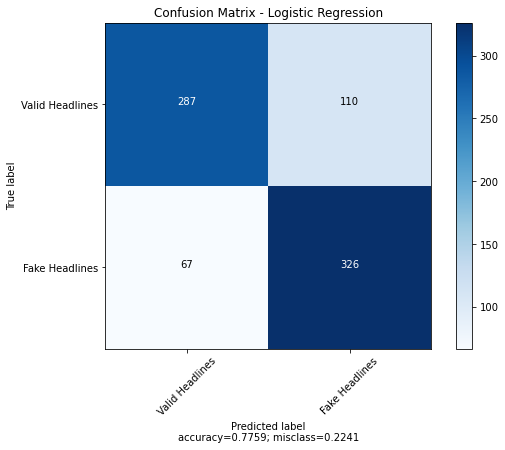

In [188]:
plot_confusion_matrix(cm=lr_confusion, target_names = ['Valid Headlines', 'Fake Headlines'], title = 'Confusion Matrix - Logistic Regression', normalize=False)

In [189]:
# print report - fake & valid headlines - logistic regression

print('----------------------Logistic Regression Report - Tf-idf----------------------\n')
print(classification_report(y_test, lr_predictions, target_names=['Fake Headlines', 'Valid Headlines']))
print('Training set score:', lr.score(X_train, y_train))
print('Test set score:', lr.score(X_test, y_test))

----------------------Logistic Regression Report - Tf-idf----------------------

                 precision    recall  f1-score   support

 Fake Headlines       0.75      0.83      0.79       393
Valid Headlines       0.81      0.72      0.76       397

       accuracy                           0.78       790
      macro avg       0.78      0.78      0.78       790
   weighted avg       0.78      0.78      0.78       790

Training set score: 0.9065864471184294
Test set score: 0.7759493670886076


In [255]:
# update stats

stats_df = stats_df.append(pd.Series(['Tf-idf','Logistic Regression',
              '0.90659', '0.77595', '0.75', '0.81', '0.83', '0.72', '0.79', 
                '0.76'], index=stats_df.columns), ignore_index=True)

In [256]:
stats_df.tail()

,F. E. Method,Model Name,Training Set Score,Test Set Score,Precision - Fake Headlines,Precision - Valid Headlines,Recall - Fake Headlines,Recall - Valid Headlines,F1-Score - Fake Headlines,F1-Score - Valid Headlines
8,1gram/2gram,Gradient Boosting,0.75174,0.70379,0.68,0.73,0.76,0.65,0.72,0.69
9,3gram,Logistic Regression,0.99937,0.59113,0.55,0.81,0.94,0.24,0.70,0.37
10,3gram,Random Forest,0.99937,0.53924,0.52,0.90,0.99,0.09,0.68,0.17
11,3gram,Gradient Boosting,0.62729,0.54303,0.52,0.89,0.99,0.10,0.68,0.19
12,Tf-idf,Logistic Regression,0.90659,0.77595,0.75,0.81,0.83,0.72,0.79,0.76


### Random Forest Model & Scores - Tf-idf

In [192]:
# random forest model & scores

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_predictions = rfc.predict(X_test)
rfc_confusion = confusion_matrix(y_test, lr_predictions, labels=[1, 0])

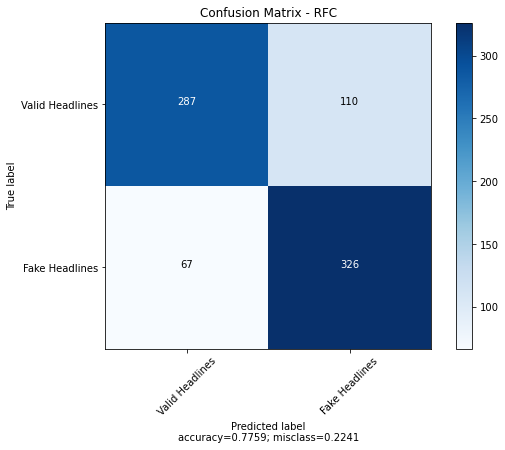

In [193]:
plot_confusion_matrix(cm=lr_confusion, target_names = ['Valid Headlines', 'Fake Headlines'], title = 'Confusion Matrix - RFC', normalize=False)

In [194]:
# print report - fake & valid headlines - rfc

print('----------------------Random Forest Report - Tf-idf----------------------\n')
print(classification_report(y_test, rfc_predictions, target_names=['Fake Headlines', 'Valid Headlines']))
print('Training set score:', rfc.score(X_train, y_train))
print('Test set score:', rfc.score(X_test, y_test))

----------------------Random Forest Report - Tf-idf----------------------

                 precision    recall  f1-score   support

 Fake Headlines       0.73      0.75      0.74       393
Valid Headlines       0.75      0.73      0.74       397

       accuracy                           0.74       790
      macro avg       0.74      0.74      0.74       790
   weighted avg       0.74      0.74      0.74       790

Training set score: 1.0
Test set score: 0.739240506329114


In [257]:
# update stats

stats_df = stats_df.append(pd.Series(['Tf-idf','Random Forest',
              '1.0', '0.73924', '0.73', '0.75', '0.75', '0.73', '0.74', 
                '0.74'], index=stats_df.columns), ignore_index=True)

In [258]:
stats_df.tail()

,F. E. Method,Model Name,Training Set Score,Test Set Score,Precision - Fake Headlines,Precision - Valid Headlines,Recall - Fake Headlines,Recall - Valid Headlines,F1-Score - Fake Headlines,F1-Score - Valid Headlines
9,3gram,Logistic Regression,0.99937,0.59113,0.55,0.81,0.94,0.24,0.70,0.37
10,3gram,Random Forest,0.99937,0.53924,0.52,0.90,0.99,0.09,0.68,0.17
11,3gram,Gradient Boosting,0.62729,0.54303,0.52,0.89,0.99,0.10,0.68,0.19
12,Tf-idf,Logistic Regression,0.90659,0.77595,0.75,0.81,0.83,0.72,0.79,0.76
13,Tf-idf,Random Forest,1.0,0.73924,0.73,0.75,0.75,0.73,0.74,0.74


### Gradient-Boosting Model & Scores - 3gram

In [204]:
# gradient-boosting model & scores

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gbc_predictions = gbc.predict(X_test)
gbc_confusion = confusion_matrix(y_test, gbc_predictions, labels=[1, 0])

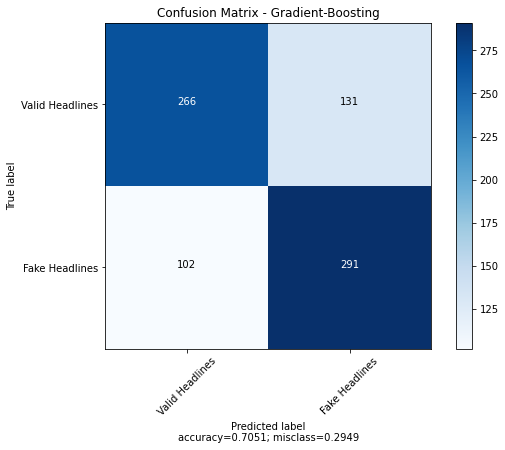

In [205]:
plot_confusion_matrix(cm=gbc_confusion, target_names = ['Valid Headlines', 'Fake Headlines'], title = 'Confusion Matrix - Gradient-Boosting', normalize=False)

In [206]:
# print report - fake & valid headlines - gradient-boosting

print('----------------------Gradient-Boosting Report - Tf-idf----------------------\n')
print(classification_report(y_test, gbc_predictions, target_names=['Fake Headlines', 'Valid Headlines']))
print('Training set score:', gbc.score(X_train, y_train))
print('Test set score:', gbc.score(X_test, y_test))

----------------------Gradient-Boosting Report - Tf-idf----------------------

                 precision    recall  f1-score   support

 Fake Headlines       0.69      0.74      0.71       393
Valid Headlines       0.72      0.67      0.70       397

       accuracy                           0.71       790
      macro avg       0.71      0.71      0.70       790
   weighted avg       0.71      0.71      0.70       790

Training set score: 0.7691576947435086
Test set score: 0.7050632911392405


In [259]:
# update stats

stats_df = stats_df.append(pd.Series(['Tf-idf','Gradient Boosting',
              '0.76916', '0.70506', '0.69', '0.72', '0.74', '0.67', '0.71', 
                '0.70'], index=stats_df.columns), ignore_index=True)

In [260]:
stats_df.tail()

,F. E. Method,Model Name,Training Set Score,Test Set Score,Precision - Fake Headlines,Precision - Valid Headlines,Recall - Fake Headlines,Recall - Valid Headlines,F1-Score - Fake Headlines,F1-Score - Valid Headlines
10,3gram,Random Forest,0.99937,0.53924,0.52,0.90,0.99,0.09,0.68,0.17
11,3gram,Gradient Boosting,0.62729,0.54303,0.52,0.89,0.99,0.10,0.68,0.19
12,Tf-idf,Logistic Regression,0.90659,0.77595,0.75,0.81,0.83,0.72,0.79,0.76
13,Tf-idf,Random Forest,1.0,0.73924,0.73,0.75,0.75,0.73,0.74,0.74
14,Tf-idf,Gradient Boosting,0.76916,0.70506,0.69,0.72,0.74,0.67,0.71,0.70


# Tf-idf & 2gram

In [209]:
vectorizer = TfidfVectorizer(
    max_df=0.5, min_df=2, use_idf=True, norm=u'l2', smooth_idf=True, ngram_range=(2,2))

X = vectorizer.fit_transform(news_headlines['Headlines'])

tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
tfidf_2_headlines = pd.concat([tfidf_df, news_headlines[['Headlines', 'Valid Source']]], axis=1)

# keep in mind that the log base 2 of 1 is 0,
# so a tf-idf score of 0 indicates that the word was present once in that sentence.
tfidf_2_headlines.head()

,000 americans,000 employees,000 in,000 jobs,000 years,10 000,10 election,10 million,10 percent,10 year,...,you ve,you warm,you wear,young people,your ass,your kids,your outdoor,your state,Headlines,Valid Source
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Chris Wallace: Trump ""bears the primary respon...",1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Biden to expand voter outreach with in-person ...,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Doomsday has arrived for tens of thousands of ...,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Pfizer CEO: COVID-19 vaccine development is ""m...",1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Anne Helen Petersen on America's burnout epidemic,1.0


In [210]:
# check for null values

tfidf_2_headlines.isnull().sum()

000 americans    2
000 employees    2
000 in           2
000 jobs         2
000 years        2
                ..
your kids        2
your outdoor     2
your state       2
Headlines        2
Valid Source     2
Length: 3681, dtype: int64

In [211]:
tfidf_2_headlines.dropna(inplace=True)

In [212]:
# confirm that null values have been dropped

tfidf_2_headlines.isnull().sum()

000 americans    0
000 employees    0
000 in           0
000 jobs         0
000 years        0
                ..
your kids        0
your outdoor     0
your state       0
Headlines        0
Valid Source     0
Length: 3681, dtype: int64

In [213]:
# split

Y = tfidf_2_headlines['Valid Source']
X = np.array(tfidf_2_headlines.drop(['Headlines','Valid Source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

### Logistic Regression Model & Scores - Tf-idf & 2gram

In [214]:
# logistic regression model & scores

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)
lr_confusion = confusion_matrix(y_test, lr_predictions, labels=[1, 0])

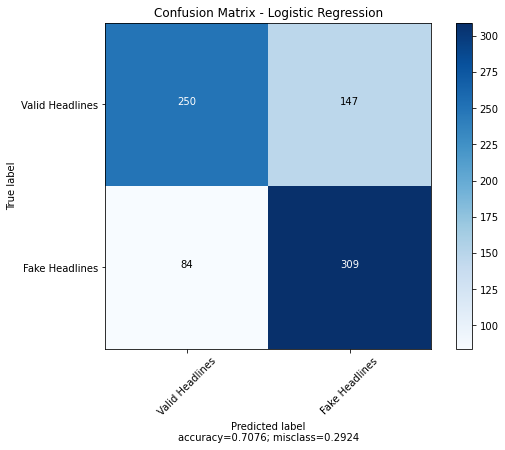

In [215]:
plot_confusion_matrix(cm=lr_confusion, target_names = ['Valid Headlines', 'Fake Headlines'], title = 'Confusion Matrix - Logistic Regression', normalize=False)

In [216]:
# print report - fake & valid headlines - logistic regression

print('----------------------Logistic Regression Report - Tf-idf & 2gram----------------------\n')
print(classification_report(y_test, lr_predictions, target_names=['Fake Headlines', 'Valid Headlines']))
print('Training set score:', lr.score(X_train, y_train))
print('Test set score:', lr.score(X_test, y_test))

----------------------Logistic Regression Report - Tf-idf & 2gram----------------------

                 precision    recall  f1-score   support

 Fake Headlines       0.68      0.79      0.73       393
Valid Headlines       0.75      0.63      0.68       397

       accuracy                           0.71       790
      macro avg       0.71      0.71      0.71       790
   weighted avg       0.71      0.71      0.71       790

Training set score: 0.8907536415452818
Test set score: 0.7075949367088608


In [261]:
# update stats

stats_df = stats_df.append(pd.Series(['Tf-idf & 2gram','Logistic Regression',
              '0.89076', '0.70759', '0.68', '0.75', '0.79', '0.63', '0.73', 
                '0.68'], index=stats_df.columns), ignore_index=True)

In [262]:
stats_df.tail()

,F. E. Method,Model Name,Training Set Score,Test Set Score,Precision - Fake Headlines,Precision - Valid Headlines,Recall - Fake Headlines,Recall - Valid Headlines,F1-Score - Fake Headlines,F1-Score - Valid Headlines
11,3gram,Gradient Boosting,0.62729,0.54303,0.52,0.89,0.99,0.10,0.68,0.19
12,Tf-idf,Logistic Regression,0.90659,0.77595,0.75,0.81,0.83,0.72,0.79,0.76
13,Tf-idf,Random Forest,1.0,0.73924,0.73,0.75,0.75,0.73,0.74,0.74
14,Tf-idf,Gradient Boosting,0.76916,0.70506,0.69,0.72,0.74,0.67,0.71,0.70
15,Tf-idf & 2gram,Logistic Regression,0.89076,0.70759,0.68,0.75,0.79,0.63,0.73,0.68


### Random Forest Model & Scores - Tf-idf & 2gram

In [219]:
# random forest model & scores

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_predictions = rfc.predict(X_test)
rfc_confusion = confusion_matrix(y_test, lr_predictions, labels=[1, 0])

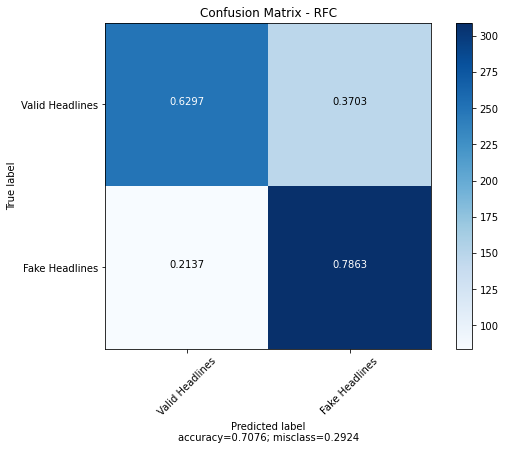

In [220]:
plot_confusion_matrix(cm=rfc_confusion, target_names = ['Valid Headlines', 'Fake Headlines'], title = 'Confusion Matrix - RFC')

In [225]:
# print report - fake & valid headlines - rfc

print('----------------------Random Forest Report - Tf-idf & 2gram----------------------\n')
print(classification_report(y_test, rfc_predictions, target_names=['Fake Headlines', 'Valid Headlines']))
print('Training set score:', lr.score(X_train, y_train))
print('Test set score:', lr.score(X_test, y_test))

----------------------Random Forest Report - Tf-idf & 2gram----------------------

                 precision    recall  f1-score   support

 Fake Headlines       0.65      0.83      0.73       393
Valid Headlines       0.77      0.56      0.65       397

       accuracy                           0.69       790
      macro avg       0.71      0.69      0.69       790
   weighted avg       0.71      0.69      0.69       790

Training set score: 0.8907536415452818
Test set score: 0.7075949367088608


In [263]:
# update stats

stats_df = stats_df.append(pd.Series(['Tf-idf & 2gram','Random Forest',
              '0.89075', '0.70759', '0.65', '0.77', '0.83', '0.56', '0.73', 
                '0.65'], index=stats_df.columns), ignore_index=True)

In [264]:
stats_df.tail()

,F. E. Method,Model Name,Training Set Score,Test Set Score,Precision - Fake Headlines,Precision - Valid Headlines,Recall - Fake Headlines,Recall - Valid Headlines,F1-Score - Fake Headlines,F1-Score - Valid Headlines
12,Tf-idf,Logistic Regression,0.90659,0.77595,0.75,0.81,0.83,0.72,0.79,0.76
13,Tf-idf,Random Forest,1.0,0.73924,0.73,0.75,0.75,0.73,0.74,0.74
14,Tf-idf,Gradient Boosting,0.76916,0.70506,0.69,0.72,0.74,0.67,0.71,0.70
15,Tf-idf & 2gram,Logistic Regression,0.89076,0.70759,0.68,0.75,0.79,0.63,0.73,0.68
16,Tf-idf & 2gram,Random Forest,0.89075,0.70759,0.65,0.77,0.83,0.56,0.73,0.65


### Gradient-Boosting Model & Scores - Tf-idf & 2gram

In [222]:
# gradient-boosting model & scores

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gbc_predictions = gbc.predict(X_test)
gbc_confusion = confusion_matrix(y_test, gbc_predictions, labels=[1, 0])

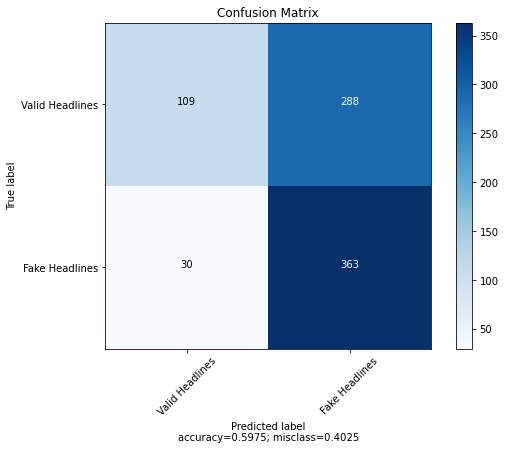

In [223]:
plot_confusion_matrix(cm=gbc_confusion, target_names = ['Valid Headlines', 'Fake Headlines'], title = 'Confusion Matrix',normalize=False)

In [224]:
# print report - fake & valid headlines - gradient-boosting

print('----------------------Gradient-Boosting Report - Tf-idf & 2gram----------------------\n')
print(classification_report(y_test, gbc_predictions, target_names=['Fake Headlines', 'Valid Headlines']))
print('Training set score:', gbc.score(X_train, y_train))
print('Test set score:', gbc.score(X_test, y_test))

----------------------Gradient-Boosting Report - Tf-idf & 2gram----------------------

                 precision    recall  f1-score   support

 Fake Headlines       0.56      0.92      0.70       393
Valid Headlines       0.78      0.27      0.41       397

       accuracy                           0.60       790
      macro avg       0.67      0.60      0.55       790
   weighted avg       0.67      0.60      0.55       790

Training set score: 0.6713109563014567
Test set score: 0.5974683544303797


In [265]:
# update stats

stats_df = stats_df.append(pd.Series(['Tf-idf & 2gram','Gradient Boosting',
              '0.67131', '0.59747', '0.56', '0.78', '0.92', '0.27', '0.70', 
                '0.41'], index=stats_df.columns), ignore_index=True)

In [266]:
stats_df.tail()

,F. E. Method,Model Name,Training Set Score,Test Set Score,Precision - Fake Headlines,Precision - Valid Headlines,Recall - Fake Headlines,Recall - Valid Headlines,F1-Score - Fake Headlines,F1-Score - Valid Headlines
13,Tf-idf,Random Forest,1.0,0.73924,0.73,0.75,0.75,0.73,0.74,0.74
14,Tf-idf,Gradient Boosting,0.76916,0.70506,0.69,0.72,0.74,0.67,0.71,0.70
15,Tf-idf & 2gram,Logistic Regression,0.89076,0.70759,0.68,0.75,0.79,0.63,0.73,0.68
16,Tf-idf & 2gram,Random Forest,0.89075,0.70759,0.65,0.77,0.83,0.56,0.73,0.65
17,Tf-idf & 2gram,Gradient Boosting,0.67131,0.59747,0.56,0.78,0.92,0.27,0.70,0.41


In [270]:
stats_df.head(18)

,F. E. Method,Model Name,Training Set Score,Test Set Score,Precision - Fake Headlines,Precision - Valid Headlines,Recall - Fake Headlines,Recall - Valid Headlines,F1-Score - Fake Headlines,F1-Score - Valid Headlines
0,Bag of Words,Logistic Regression,0.98100,0.76582,0.75,0.79,0.80,0.73,0.77,0.76
1,Bag of Words,Random Forest,1.0,0.73164,0.71,0.77,0.79,0.67,0.75,0.72
2,Bag of Words,Gradient Boosting,0.75269,0.70379,0.68,0.73,0.76,0.65,0.72,0.69
3,2gram,Logistic Regression,0.99968,0.69747,0.66,0.76,0.82,0.58,0.73,0.66
4,2gram,Random Forest,0.99937,0.61392,0.57,0.87,0.96,0.27,0.71,0.41
5,2gram,Gradient Boosting,0.65484,0.59747,0.56,0.83,0.95,0.25,0.70,0.39
6,1gram/2gram,Logistic Regression,1.0,0.781013,0.76,0.81,0.82,0.74,0.79,0.77
7,1gram/2gram,Random Forest,1.0,0.72911,0.69,0.79,0.83,0.63,0.75,0.70
8,1gram/2gram,Gradient Boosting,0.75174,0.70379,0.68,0.73,0.76,0.65,0.72,0.69
9,3gram,Logistic Regression,0.99937,0.59113,0.55,0.81,0.94,0.24,0.70,0.37


## **Results:** 

While there is less variation between test and training scores of the gradient boosting models, additional data should be used for training purposes to minimize overfitting. Training test scores from random forest and logistic regression models indicate overfitting.

Precision scores for valid headlines are higher than the precision scores of fake headlines. Recall scores are higher across the board for fake headlines. F1-scores are generally higher for fake headlines as well. 

From these scores, we can determine that our models are identifying valid headlines more correctly than fake headlines while identifying a larger fraction of fake headlines (higher recall). 

After examining the scores from various models and approaches to featuring engineering, our logistic regression models appear to be the top performers for Bag of Words and 1gram/2gram language models. Logistic regression and gradient boosting models performed best for Tf-idf.

**Final model selection for subsequent training and predictions:** Tf-idf with logistic regression model.

# Additional Projects

## Text Generation & Chatbot

# Text Generation - Markov Chain

## Generate Fake Headlines

**Note:** .txt files used for headline generation feature the same scraped headlines as our initial dataset, split into fake and valid sources.

In [271]:
with open(r'/Users/thisiskatcooper/Desktop/fake_headlines.txt') as f:
    fake_headlines = f.read()

In [273]:
fake_headline_model = markovify.NewlineText(fake_headlines)

# print five randomly generated sentences

for i in range(5):
    print(fake_headline_model.make_sentence())
    
print('\n------------------------------------\n')

# print three randomly generated sentences of no more than 100 characters

for i in range(5):
    print(fake_headline_model.make_short_sentence(100))

Country Time CEO Unsure If Company Supposed To Be Settled By An Election
Silicon Valley Billionaires Unveil Diversity Initiative To Replace Police Officers Suspended After Staining Clean Sidewalk With Blood
General Mattis Condemns Trump As Threat To White Person By Crossing To Other Dimension
Mike Tyson Offered $20 Million To Support Strategy Of Giving LeBron James Coronavirus
Secret Recording Shows That Melania Trump Renegotiated Prenup Before Moving Into White House

------------------------------------

Trump: “Now I Want to Buy Fox News Limits Pandemic Coverage To Avoid Alienating Swing Voters
Trump Visits Kenosha, Wisconsin Despite Pleas To Stay Connected To Country Does
The Week In Pictures – Week Of Show Ideas After Hispanic Cashier Gives Him Wrong Change
WHO Walks Back Halloween Cancellation
Will Smith Reveals Extramarital Relationship With Food Right Now


Pretty good, overall!

## Generate Valid Headlines

In [274]:
with open(r'/Users/thisiskatcooper/Desktop/valid_headlines.txt') as f:
    valid_headlines = f.read()

In [276]:
valid_headline_model = markovify.NewlineText(valid_headlines)

# print five randomly generated sentences

for i in range(5):
    print(valid_headline_model.make_sentence())
    
print('\n------------------------------------\n')

# print three randomly generated sentences of no more than 100 characters

for i in range(5):
    print(valid_headline_model.make_short_sentence(100))

Inside Room 239: How Alexei Navalny’s aides got crucial poisoning evidence out of the Most Daring Women Spies of World War II
America is in control
Founder of the debate
Coronavirus FAQs: Why Can't The CDC Has Banned Them ― For Now
‘SNL’ review: With Trump in the decisive Game 3 vs. the A’s

------------------------------------

What I Saw at the edge of the free-spirited fashion house Kenzo dies at 84
This is everywhere you should be just as careful about covid-19 in Latino communities
Canceling the remaining debates would be bad for everyone but bigots
U.S. faces shortage of up to hunt for air leak to Russian side of space station after midnight alarm
Will You Leave the Country if Trump Is a Bizarre Cinematic Experiment


**Note:** Interestingly, though logically, the "valid" headlines generated seem less convincing than the fake headlines. Perhaps this could be refined further by addressing grammar issues (parts of speech).

# Chatbot

**Note:** Headlines included are a .txt file of the same headlines featured throughout this project.

In [277]:
import random
import string

In [278]:
f=open('/Users/thisiskatcooper/Desktop/extracts.txt','r', errors = 'ignore')
raw=f.read()
sent_tokens = nltk.sent_tokenize(raw)
word_tokens = nltk.word_tokenize(raw)

In [279]:
# pre-processing - normalize tokesn

lemmer = nltk.stem.WordNetLemmatizer()
def LemTokens(tokens):
    return [lemmer.lemmatize(token) for token in tokens]
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [280]:
GREETING_INPUTS = ("hello", "hi", "greetings", "sup", "what's up","hey", "Hello", "Hi")
GREETING_RESPONSES = ["hi", "hey", "*nods*", "hi there", "hello", "what's up?"]

def greeting(sentence):
 
    for word in sentence.split():
        if word.lower() in GREETING_INPUTS:
            return random.choice(GREETING_RESPONSES)

In [281]:
stop_words = nltk.corpus.stopwords.words('english')
stop_words.append('you')

In [282]:
def response(user_response):
    fakerbot_response=''
    sent_tokens.append(user_response)
    TfidfVec = TfidfVectorizer(tokenizer=LemNormalize, lowercase=False, stop_words='english')
    stop_words.append('you')
    tfidf = TfidfVec.fit_transform(sent_tokens)
    vals = cosine_similarity(tfidf[-1], tfidf[:-1])
    idx=vals.argsort()[0][-4]
    flat = vals.flatten()
    flat.sort()
    req_tfidf = flat[-2]
    if(req_tfidf==0):
        faekerbot_response=fakerbot_response+"I am sorry! I don't understand you."
        return fakerbot_response
    else:
        fakerbot_response = fakerbot_response+sent_tokens[idx]
        return fakerbot_response.lower().capitalize()

In [284]:
flag=True
print("Fakerbot: My name is Fakerbot. Let's talk. If you're over it, type 'Bye!''")
while(flag==True):
    user_response = input()
    user_response=user_response.lower()
    if(user_response!='bye'):
        if(user_response=='thanks' or user_response=='thank you' ):
            flag=False
            print("Fakerbot: No worries.")
        else:
            if(greeting(user_response)!=None):
                print("Fakerbot: "+greeting(user_response))
            else:
                print("Fakerbot: ", end="")
                print(response(user_response))
                sent_tokens.remove(user_response)
    else:
        flag=False
        print("Fakerbot: Alright. Bye. Got other things to do.")

Fakerbot: My name is Fakerbot. Let's talk. If you're over it, type 'Bye!''
hello
Fakerbot: what's up?
Does Megan Markle like cats?
Fakerbot: Cat too evil to pet, too soft not to.
Where do you live?
Fakerbot: Economist has great idea for sitcom where keynesian and friedmanite have to live together.
bye
Fakerbot: Alright. Bye. Got other things to do.


Not too shabby, although we could continue to improve Fakerbot.

**Note:** question asked was posed on frequency of certain words (people, places, things, etc.) in the scraped satirical news headlines. Perhaps we could discuss a more extensive range of topics by increasing the size of the dataset or by making changes to the model.

# Further Steps:

- Scraping additional data could and would lead to improved performance for headline prediction models. 

- Additionally, experimenting with stop words could also lead to increased scores and performance. 

- Text generation and chatbot programs could also be fine-tuned to create more convincing results.